In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import matplotlib.cm as cm
import numpy.matlib
from sklearn.metrics import average_precision_score
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [59]:
### QUESTION A
seeds_data = pd.read_csv("housing1.csv").values.astype(np.float64)
mean_data = seeds_data.mean(0)
print( mean_data)
std_data = seeds_data.std(0)
norm_data = (seeds_data - mean_data)/std_data
#print(norm_data)

[ 3.84189770e+00  3.75175175e+01  5.22609442e+00  1.05234063e+00
  1.21943644e+03  2.71599563e+00  3.77395195e+01 -1.22155886e+02
  2.09500412e+00]


In [55]:
### QUESTION B
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def pick_random_entry(data, amount=1):
    return data[np.random.choice(data.shape[0], amount, replace=False), :]

def kMean(points, centroids):
    groups = [[] for x in range(centroids.shape[0])]
    intra_distance = 0

    for idx1, point in enumerate(points):
        closest = (-1, 0)
        for idx2, centroid in enumerate(centroids):
            distance = euclidean_distance(point, centroid)
            closest_distance, closest_index = closest
            if (closest_distance == -1 or distance < closest_distance):
                closest = (distance, idx2)
        groups[closest[1]].append(point)
        intra_distance = intra_distance + closest[0]**2
    new_centroids = []
    for idx, group in enumerate(groups):
        new_centroids.append(np.mean(group, 0))
    new_centroids = np.array(new_centroids)
    if (np.array_equal(centroids, new_centroids)):
        return groups, new_centroids, intra_distance
    return kMean(points, new_centroids)

def kMean_optimized(data, clusters, iterations):
    best = (np.zeros(0), np.zeros(0), -1)
    for i in range(iterations):
        points, centroids, intra_distance = kMean(data, pick_random_entry(data, clusters))
        if (best[2] == -1 or intra_distance < best[2]):
            best = (points, centroids, intra_distance)
    return best


k0 = 2
k1 = 2
times = 5

#Level 1
groups, centroids, intra_distance = kMean_optimized(norm_data, k0, times)
print("Level 1")
print("Smallest intra-cluster distance: ", intra_distance)
print("Number of samples in clusters: ", [np.array(g).shape[0] for g in groups])

#Level 2
print("\nLevel 2")
clusters = []
centroids2 = []
for i in range(k0): # K_0 is the number of clusters in the first level
    data_cluster = np.array(groups[i]) # get the data for the i-th group
    
    groups2, centroids, intra_distance = kMean_optimized(data_cluster, k1, times) # initialize KMeans for the second level with K_1 clusters
    clusters.append(groups2)
    centroids2.append(centroids)
    print("Smallest intra-cluster distance in group ", i, ": ", intra_distance)
    print("Number of samples in group ", i, ": ", data_cluster.shape[0])
    print("Number of samples in sub-clusters: ", [np.array(x).shape[0] for x in groups2],"\n")

Level 1
Smallest intra-cluster distance:  6743.846398084127
Number of samples in clusters:  [385, 614]

Level 2
Smallest intra-cluster distance in group  0 :  2537.9501403237477
Number of samples in group  0 :  385
Number of samples in sub-clusters:  [300, 85] 

Smallest intra-cluster distance in group  1 :  2787.0404830696434
Number of samples in group  1 :  614
Number of samples in sub-clusters:  [365, 249] 



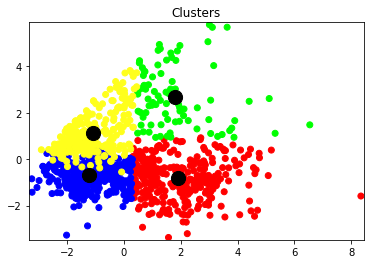

In [56]:
### QUESTION C AND D
def __PCA(data):
    pca = PCA(n_components=2)   # returns a 2D
    return pca.fit(data)

## Combining the two clusters from level 2
combined_groups = clusters[0] + clusters[1]

pca_flattened = []
group_map = []
for idx, group in enumerate(combined_groups):
    for point in group:
        group_map.append(idx)
        point = np.array(point)
        pca_flattened.append(point)
pca_flattened = np.array(pca_flattened)
pca_data = __PCA(pca_flattened)
transformed_data = pca_data.transform(pca_flattened)
transformed_centroids = pca_data.transform(centroids2[0])
transformed_centroids2 = pca_data.transform(centroids2[1])

def visualize(points, centroids, centroids2, group_map):
    plt.figure()
    cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF','#ffff1c'])
    plt.title("Clusters")
    plt.scatter(points[:, 0], points[:, 1], c = group_map, cmap = cmap_bold)
    plt.scatter(centroids[:, 0], centroids[:, 1], c = "#000000", s=200)
    plt.scatter(centroids2[:, 0], centroids2[:, 1], c = "#000000", s=200)
    plt.xlim(points[:, 0].min() - 0.1, points[:, 0].max() + 0.1)
    plt.ylim(points[:, 1].min() - 0.1, points[:, 1].max() + 0.1)
    plt.show()

visualize(transformed_data, transformed_centroids, transformed_centroids2, group_map)